# Gut Microbiome Machine Learning Pipeline
Feature Engineering & Disease vs Healthy Classification Models

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (StratifiedKFold, cross_validate,
                                     train_test_split, cross_val_predict)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, balanced_accuracy_score,make_scorer)

sns.set(style="whitegrid", font_scale=1.05)
np.random.seed(2025)


# 1. Load Preprocessed Data from EDA

In [2]:
# Define paths (assuming EDA script has been run)
data_dir = "data"
RESULTS = os.path.join(data_dir, "results_EDA")
FIGS = os.path.join(RESULTS, "figures")
TABLES = os.path.join(RESULTS, "tables")

# Ensure ML results directory exists
ML_FIGS = os.path.join(RESULTS, "ml_figures")
ML_TABLES = os.path.join(RESULTS, "ml_tables")
os.makedirs(ML_FIGS, exist_ok=True)
os.makedirs(ML_TABLES, exist_ok=True)


In [3]:
# Load preprocessed data from EDA
print("Loading preprocessed data from EDA...")

ab_clr = pd.read_csv(os.path.join(TABLES, "abundance_clr.csv"), index_col=0)
meta = pd.read_csv(os.path.join(TABLES, "metadata_with_disease_groups.csv"), index_col=0)
alpha = pd.read_csv(os.path.join(TABLES, "alpha_diversity.csv"), index_col=0)

# Load original relative abundance for feature engineering
ab_rel = pd.read_csv(os.path.join(TABLES, "abundance_filtered_relative.csv"), index_col=0)

print(f"\nLoaded data:")
print(f"  CLR-transformed abundances: {ab_clr.shape}")
print(f"  Metadata: {meta.shape}")
print(f"  Alpha diversity: {alpha.shape}")
print(f"  Relative abundances: {ab_rel.shape}")

# Align all datasets
common_idx = ab_clr.index.intersection(meta.index).intersection(alpha.index)
ab_clr = ab_clr.loc[common_idx]
ab_rel = ab_rel.loc[common_idx]
meta = meta.loc[common_idx]
alpha = alpha.loc[common_idx]

print(f"\nAfter alignment: {len(common_idx)} samples")

# Create binary labels: Healthy (0) vs Disease (1)
y = (meta['health_status'] == 'Disease').astype(int).values

print(f"\nClass distribution (full dataset):")
print(f"  Healthy: {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"  Disease: {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")


Loading preprocessed data from EDA...

Loaded data:
  CLR-transformed abundances: (1831, 362)
  Metadata: (1831, 28)
  Alpha diversity: (1831, 5)
  Relative abundances: (1831, 362)

After alignment: 1831 samples

Class distribution (full dataset):
  Healthy: 642 (35.1%)
  Disease: 1189 (64.9%)


# 2. Train/Test Split (Held-out Test Set)

In [4]:

print("CREATING TRAIN/TEST SPLIT")

train_idx, test_idx = train_test_split(
    np.arange(len(y)),
    test_size=0.2,
    stratify=y,
    random_state=2025
)

y_train = y[train_idx]
y_test = y[test_idx]

print(f"\nTraining set:")
print(f"  Total: {len(y_train)} samples")
print(f"  Healthy: {(y_train==0).sum()} ({(y_train==0).mean()*100:.1f}%)")
print(f"  Disease: {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")

print(f"\nTest set (held-out):")
print(f"  Total: {len(y_test)} samples")
print(f"  Healthy: {(y_test==0).sum()} ({(y_test==0).mean()*100:.1f}%)")
print(f"  Disease: {(y_test==1).sum()} ({(y_test==1).mean()*100:.1f}%)")

# Store indices for later use
sample_indices = {
    'train': train_idx,
    'test': test_idx
}


CREATING TRAIN/TEST SPLIT

Training set:
  Total: 1464 samples
  Healthy: 513 (35.0%)
  Disease: 951 (65.0%)

Test set (held-out):
  Total: 367 samples
  Healthy: 129 (35.1%)
  Disease: 238 (64.9%)


# 2. Feature Engineering

In [5]:
def engineer_ratio_features(ab_rel, top_n=50):
    """
    Create ratio features between abundant taxa.
    These can capture ecological relationships.
    """
    print("\nEngineering ratio features...")

    # Select top N most abundant taxa
    mean_abundance = ab_rel.mean(axis=0).sort_values(ascending=False)
    top_taxa = mean_abundance.head(top_n).index

    ratio_features = pd.DataFrame(index=ab_rel.index)

    # Create key ratios
    for i, taxon1 in enumerate(top_taxa[:10]):
        for taxon2 in top_taxa[i+1:15]:
            ratio_name = f"ratio_{taxon1[:20]}_{taxon2[:20]}"
            ratio_features[ratio_name] = np.log10(
                (ab_rel[taxon1] + 1e-6) / (ab_rel[taxon2] + 1e-6)
            )

    print(f"  Created {ratio_features.shape[1]} ratio features")
    return ratio_features


In [6]:
def engineer_clinical_features(meta):
    """
    Extract and engineer features from clinical metadata.
    """
    print("\nEngineering clinical features...")

    clinical_features = pd.DataFrame(index=meta.index)
    n_features = 0

    # 1. BMI features
    if 'BMI' in meta.columns:
        clinical_features['BMI'] = meta['BMI'].astype(float)
        clinical_features['is_obese'] = (meta['BMI'] >= 30).astype(float)
        clinical_features['is_overweight'] = ((meta['BMI'] >= 25) & (meta['BMI'] < 30)).astype(float)
        n_features += 3
        print(f"  ✓ BMI features: {meta['BMI'].notna().sum()} samples with data")

    # 2. Age categories
    if 'age_category' in meta.columns:
        age_dummies = pd.get_dummies(meta['age_category'], prefix='age', drop_first=True)
        clinical_features = pd.concat([clinical_features, age_dummies], axis=1)
        n_features += age_dummies.shape[1]
        print(f"  ✓ Age categories: {age_dummies.shape[1]} features")

    # 3. Gender
    if 'gender' in meta.columns:
        clinical_features['is_male'] = (meta['gender'].str.lower() == 'male').astype(float)
        n_features += 1
        print(f"  ✓ Gender: {clinical_features['is_male'].notna().sum()} samples")

    # 4. Metabolic markers (z-scored)
    metabolic_markers = ['triglycerides', 'hba1c', 'LDL', 'HDL', 'hsCRP']
    for marker in metabolic_markers:
        if marker in meta.columns:
            values = meta[marker].astype(float)
            if values.notna().sum() > 10:  # Only if enough data
                mean = values.mean()
                std = values.std()
                if std > 0:
                    clinical_features[f'{marker}_zscore'] = (values - mean) / std
                    n_features += 1
                    print(f"  ✓ {marker}: {values.notna().sum()} samples")

    # 5. Smoking status
    if 'smoke' in meta.columns:
        clinical_features['is_smoker'] = meta['smoke'].notna().astype(float)
        n_features += 1

    # 6. Antibiotic use
    if 'antibiotic_use' in meta.columns:
        clinical_features['antibiotic_yes'] = (meta['antibiotic_use'] == 'yes').astype(float)
        clinical_features['antibiotic_unknown'] = (meta['antibiotic_use'] == 'unknown').astype(float)
        n_features += 2
        print(f"  ✓ Antibiotics: yes={clinical_features['antibiotic_yes'].sum()}, "
              f"unknown={clinical_features['antibiotic_unknown'].sum()}")

    # 7. Country/Region (if available)
    if 'country' in meta.columns:
        country_counts = meta['country'].value_counts()
        common_countries = country_counts[country_counts > 50].index
        if len(common_countries) > 1:
            meta['country_grouped'] = meta['country'].apply(
                lambda x: x if x in common_countries else 'other'
            )
            country_dummies = pd.get_dummies(meta['country_grouped'], prefix='country', drop_first=True)
            clinical_features = pd.concat([clinical_features, country_dummies], axis=1)
            n_features += country_dummies.shape[1]
            print(f"  ✓ Country: {country_dummies.shape[1]} features")

    print(f"\nTotal clinical features: {n_features}")

    return clinical_features


In [7]:
def combine_feature_sets(ab_clr, alpha, clinical_features=None, ratio_features=None):
    """
    Combine different feature sets into a single matrix.
    """
    print("\nCombining feature sets...")

    feature_sets = [ab_clr]
    feature_names = ['microbiome_clr']

    # Add alpha diversity
    if alpha is not None:
        alpha_subset = alpha[['richness', 'shannon', 'simpson']]
        feature_sets.append(alpha_subset)
        feature_names.append('alpha_diversity')

    # Add ratio features
    if ratio_features is not None:
        feature_sets.append(ratio_features)
        feature_names.append('ratio_features')

    # Add clinical features
    if clinical_features is not None:
        feature_sets.append(clinical_features)
        feature_names.append('clinical')

    # Combine
    X_combined = pd.concat(feature_sets, axis=1)

    # Handle missing values
    # Binary features: fill with 0
    # Continuous: fill with median
    for col in X_combined.columns:
        if X_combined[col].isna().any():
            if X_combined[col].nunique() <= 2:
                X_combined[col] = X_combined[col].fillna(0)
            else:
                X_combined[col] = X_combined[col].fillna(X_combined[col].median())

    print(f"\nCombined feature matrix: {X_combined.shape}")
    print(f"Feature sets included: {', '.join(feature_names)}")
    print(f"Missing values remaining: {X_combined.isna().sum().sum()}")

    print("Total samples and features:", X_combined.shape)

    return X_combined


In [8]:
# Create feature sets
print("FEATURE ENGINEERING")

ratio_features = engineer_ratio_features(ab_rel, top_n=50)
clinical_features = engineer_clinical_features(meta)

# Create different feature combinations
X_microbiome = ab_clr.copy()
X_microbiome_alpha = combine_feature_sets(ab_clr, alpha, None, None)
X_full = combine_feature_sets(ab_clr, alpha, clinical_features, ratio_features)

print(f"\nFeature matrices created:")
print(f"  1. Microbiome-only (CLR):                    {X_microbiome.shape}")
print(f"  2. Microbiome + Alpha diversity:             {X_microbiome_alpha.shape}")
print(f"  3. Full (microbiome + alpha + clinical):     {X_full.shape}")


FEATURE ENGINEERING

Engineering ratio features...
  Created 95 ratio features

Engineering clinical features...
  ✓ BMI features: 1310 samples with data
  ✓ Age categories: 1 features
  ✓ Gender: 1831 samples
  ✓ triglycerides: 844 samples
  ✓ hba1c: 839 samples
  ✓ LDL: 841 samples
  ✓ hsCRP: 829 samples
  ✓ Antibiotics: yes=783.0, unknown=104.0
  ✓ Country: 2 features

Total clinical features: 14

Combining feature sets...

Combined feature matrix: (1831, 365)
Feature sets included: microbiome_clr, alpha_diversity
Missing values remaining: 0
Total samples and features: (1831, 365)

Combining feature sets...

Combined feature matrix: (1831, 474)
Feature sets included: microbiome_clr, alpha_diversity, ratio_features, clinical
Missing values remaining: 0
Total samples and features: (1831, 474)

Feature matrices created:
  1. Microbiome-only (CLR):                    (1831, 362)
  2. Microbiome + Alpha diversity:             (1831, 365)
  3. Full (microbiome + alpha + clinical):     (18

# 4. Model Training & Evaluation Functions

In [9]:
def train_and_evaluate_model(X, y, train_idx, test_idx, model_type='logistic',
                            n_cv_folds=5, feature_selection=None, n_features=100, logistic_penalty = 'l2', rf_n_estimators=200,
            rf_max_depth=10):
    """
    Train and evaluate a model with proper train/test split.

    Parameters:
    -----------
    X : DataFrame - Feature matrix
    y : array - Binary labels (0=Healthy, 1=Disease)
    train_idx : array - Training set indices
    test_idx : array - Test set indices
    model_type : str - 'logistic', or 'random_forest'
    n_cv_folds : int - Number of cross-validation folds (on training set only)
    feature_selection : str - 'univariate' or None
    n_features : int - Number of features to select
    """

    # Split data
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train_set = y[train_idx]
    y_test_set = y[test_idx]

    # Feature selection (fit on training set only)
    selected_features = None
    if feature_selection == 'univariate':
        print(f"\nPerforming univariate feature selection (top {n_features})...")
        selector = SelectKBest(f_classif, k=min(n_features, X_train.shape[1]))
        X_train_transformed = selector.fit_transform(X_train.values, y_train_set)
        X_test_transformed = selector.transform(X_test.values)

        selected_features = X_train.columns[selector.get_support()].tolist()
        print(f"  Selected {len(selected_features)} features")

        X_train = pd.DataFrame(X_train_transformed,
                              index=X_train.index,
                              columns=selected_features)
        X_test = pd.DataFrame(X_test_transformed,
                             index=X_test.index,
                             columns=selected_features)

    # Initialize model
    if model_type == 'logistic':
        model = LogisticRegressionCV(
            cv=5,
            penalty=logistic_penalty,
            max_iter=1000,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1,
            scoring='roc_auc'
        )
        model_name = 'Logistic Regression (L2)'
    elif model_type == 'random_forest':
        model = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            max_depth=rf_max_depth,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1
        )
        model_name = 'Random Forest'

    print(f"\nModel: {model_name}")
    print(f"Training samples: {len(y_train_set)}, Test samples: {len(y_test_set)}")

    # Cross-validation on TRAINING SET ONLY
    cv = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=2025)

    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'balanced_acc': make_scorer(balanced_accuracy_score),
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    print(f"\nPerforming {n_cv_folds}-fold cross-validation on training set...")
    cv_results = cross_validate(
        model, X_train.values, y_train_set,
        cv=cv,
        scoring=scoring,
        return_train_score=False,  # Only validation scores
        n_jobs=-1
    )

    # Print CV results (validation during training)
    print(f"\nCross-Validation Results (on training set):")
    print(f"{'Metric':<15} {'CV Mean':<20}")


    cv_results_dict = {}
    for metric in scoring.keys():
        cv_mean = cv_results[f'test_{metric}'].mean()
        cv_std = cv_results[f'test_{metric}'].std()

        cv_results_dict[metric] = {
            'cv_mean': cv_mean,
            'cv_std': cv_std
        }

        print(f"{metric:<15} {cv_mean:.3f} ± {cv_std:.3f}")

    # Train final model on FULL training set
    print(f"\nTraining final model on full training set...")
    model.fit(X_train.values, y_train_set)

    # Evaluate on HELD-OUT TEST SET
    print(f"\nEvaluating on held-out test set...")
    y_test_pred = model.predict(X_test.values)
    y_test_prob = model.predict_proba(X_test.values)[:, 1]

    # Calculate test metrics
    test_results = {
        'roc_auc': roc_auc_score(y_test_set, y_test_prob),
        'accuracy': (y_test_set == y_test_pred).mean(),
        'balanced_acc': balanced_accuracy_score(y_test_set, y_test_pred),
        'precision': ((y_test_pred == 1) & (y_test_set == 1)).sum() / max((y_test_pred == 1).sum(), 1),
        'recall': ((y_test_pred == 1) & (y_test_set == 1)).sum() / max((y_test_set == 1).sum(), 1),
    }
    test_results['f1'] = 2 * test_results['precision'] * test_results['recall'] / max(test_results['precision'] + test_results['recall'], 1e-10)

    print(f"\nTest Set Results:")
    print(f"{'Metric':<15} {'Test Score':<20}")

    for metric, value in test_results.items():
        print(f"{metric:<15} {value:.3f}")
        cv_results_dict[metric]['test_score'] = value

    # Calculate generalization gap
    generalization_gap = cv_results_dict['roc_auc']['cv_mean'] - test_results['roc_auc']
    print(f"\nGeneralization Analysis:")
    print(f"  CV AUC (training):  {cv_results_dict['roc_auc']['cv_mean']:.3f}")
    print(f"  Test AUC (held-out): {test_results['roc_auc']:.3f}")
    print(f"  Gap: {generalization_gap:+.3f}")

    if abs(generalization_gap) > 0.05:
        if generalization_gap > 0:
            print(f"Model may be slightly overfit to training data")
        else:
            print(f"Model generalizes well (test better than CV)")
    else:
        print(f"Good generalization")

    # Extract feature importance
    feature_importance = None
    if model_type == 'logistic':
        coefs = model.coef_[0]
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'coefficient': coefs,
            'abs_coefficient': np.abs(coefs)
        }).sort_values('abs_coefficient', ascending=False)

        print(f"\nTop 15 Features (Logistic Regression Coefficients):")
        print(f"{'Feature':<50} {'Coefficient':>12} {'Direction'}")

        for _, row in feature_importance.head(15).iterrows():
            direction = '↑ Disease' if row['coefficient'] > 0 else '↓ Disease'
            feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
            print(f"{feat_name:<50} {row['coefficient']:>12.4f}  {direction}")

    elif model_type in ['random_forest', 'gradient_boosting']:
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print(f"\nTop 15 Features (Feature Importance):")
        print(f"{'Feature':<50} {'Importance':>12}")
        for _, row in feature_importance.head(15).iterrows():
            feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
            print(f"{feat_name:<50} {row['importance']:>12.4f}")

    return {
        'model': model,
        'model_name': model_name,
        'cv_results': cv_results_dict,
        'y_test': y_test_set,
        'y_test_pred': y_test_pred,
        'y_test_prob': y_test_prob,
        'feature_importance': feature_importance,
        'X_train': X_train,
        'X_test': X_test,
        'selected_features': selected_features
    }


# 5. Model Training
1. Random Forest
2. clinical + alpha + microbial features

In [10]:
results = {}

In [11]:
# Model 6: Random Forest (full features)
print("RANDOM FOREST (full features)")

results['full_features_rf'] = train_and_evaluate_model(
    X_full, y, train_idx, test_idx,
    model_type='random_forest',
    n_cv_folds=5,
    feature_selection='univariate',
    n_features=150,
    rf_n_estimators=200,
    rf_max_depth=10
)


RANDOM FOREST (full features)

Performing univariate feature selection (top 150)...
  Selected 150 features

Model: Random Forest
Training samples: 1464, Test samples: 367

Performing 5-fold cross-validation on training set...

Cross-Validation Results (on training set):
Metric          CV Mean             
roc_auc         0.919 ± 0.018
accuracy        0.886 ± 0.013
balanced_acc    0.851 ± 0.018
precision       0.871 ± 0.016
recall          0.967 ± 0.007
f1              0.917 ± 0.009

Training final model on full training set...

Evaluating on held-out test set...

Test Set Results:
Metric          Test Score          
roc_auc         0.894
accuracy        0.850
balanced_acc    0.805
precision       0.835
recall          0.958
f1              0.892

Generalization Analysis:
  CV AUC (training):  0.919
  Test AUC (held-out): 0.894
  Gap: +0.025
Good generalization

Top 15 Features (Feature Importance):
Feature                                              Importance
hba1c_zscore         

## Model Comparison Visualizations

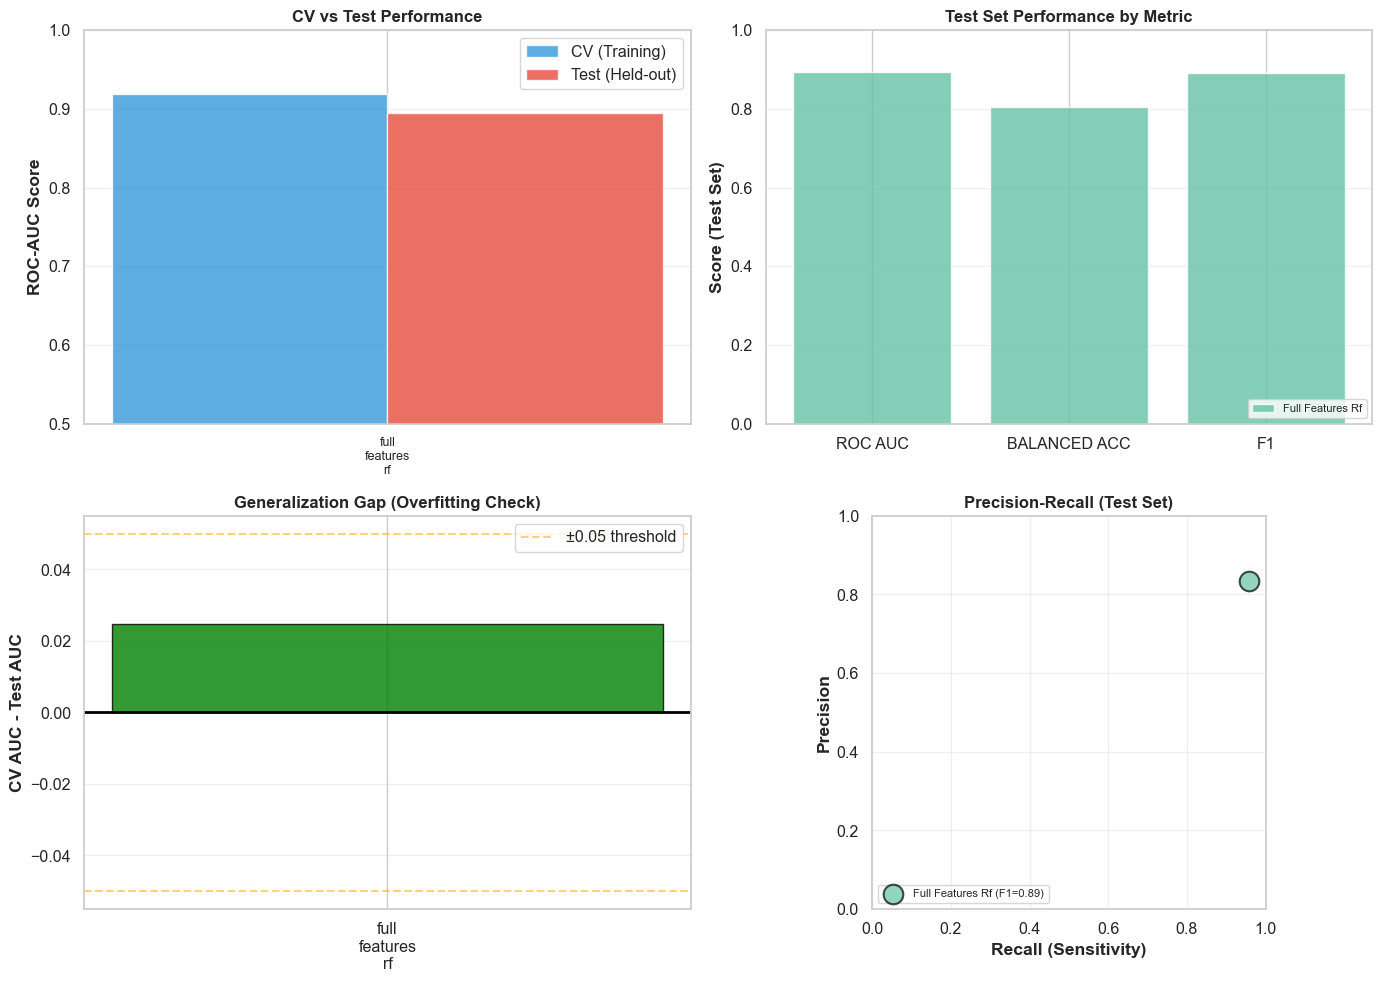

In [12]:
def plot_model_stats(results_dict):
    """
    Create comprehensive comparison plots showing CV and Test performance.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    models = list(results_dict.keys())
    metrics = ['roc_auc', 'balanced_acc', 'f1']
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))

    # 1. CV vs Test Performance Comparison
    ax = axes[0, 0]
    x = np.arange(len(models))
    width = 0.35

    cv_aucs = [results_dict[m]['cv_results']['roc_auc']['cv_mean'] for m in models]
    test_aucs = [results_dict[m]['cv_results']['roc_auc']['test_score'] for m in models]

    ax.bar(x - width/2, cv_aucs, width, label='CV (Training)', alpha=0.8, color='#3498DB')
    ax.bar(x + width/2, test_aucs, width, label='Test (Held-out)', alpha=0.8, color='#E74C3C')

    ax.set_ylabel('ROC-AUC Score', fontweight='bold')
    ax.set_title('CV vs Test Performance', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', '\n') for m in models], fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.5, 1.0])
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    # 2. Test Set Performance Across Metrics
    ax = axes[0, 1]
    x = np.arange(len(metrics))
    width = 0.8 / len(models)

    for i, (model_name, color) in enumerate(zip(models, colors)):
        values = [results_dict[model_name]['cv_results'][m]['test_score'] for m in metrics]

        ax.bar(x + i*width, values, width,
               label=model_name.replace('_', ' ').title(),
               alpha=0.8, color=color)

    ax.set_ylabel('Score (Test Set)', fontweight='bold')
    ax.set_title('Test Set Performance by Metric', fontweight='bold', fontsize=12)
    ax.set_xticks(x + width * (len(models)-1) / 2)
    ax.set_xticklabels([m.upper().replace('_', ' ') for m in metrics])
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])

    # 3. Generalization Gap Analysis
    ax = axes[1, 0]

    gaps = []
    for model_name in models:
        cv_auc = results_dict[model_name]['cv_results']['roc_auc']['cv_mean']
        test_auc = results_dict[model_name]['cv_results']['roc_auc']['test_score']
        gap = cv_auc - test_auc
        gaps.append(gap)

    colors_bars = ['green' if abs(g) < 0.05 else 'orange' if abs(g) < 0.1 else 'red' for g in gaps]
    ax.bar([m.replace('_', '\n') for m in models], gaps, alpha=0.8, color=colors_bars, edgecolor='black')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='±0.05 threshold')
    ax.axhline(y=-0.05, color='orange', linestyle='--', alpha=0.5)

    ax.set_ylabel('CV AUC - Test AUC', fontweight='bold')
    ax.set_title('Generalization Gap (Overfitting Check)', fontweight='bold', fontsize=12)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # 4. Precision-Recall on Test Set
    ax = axes[1, 1]

    for i, (model_name, color) in enumerate(zip(models, colors)):
        precision = results_dict[model_name]['cv_results']['precision']['test_score']
        recall = results_dict[model_name]['cv_results']['recall']['test_score']
        f1 = results_dict[model_name]['cv_results']['f1']['test_score']

        ax.scatter(recall, precision, s=200, alpha=0.7, color=color,
                  label=f"{model_name.replace('_', ' ').title()} (F1={f1:.2f})",
                  edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Recall (Sensitivity)', fontweight='bold')
    ax.set_ylabel('Precision', fontweight='bold')
    ax.set_title('Precision-Recall (Test Set)', fontweight='bold', fontsize=12)
    ax.legend(fontsize=8, loc='lower left')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'model_comparison_comprehensive.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

plot_model_stats(results)


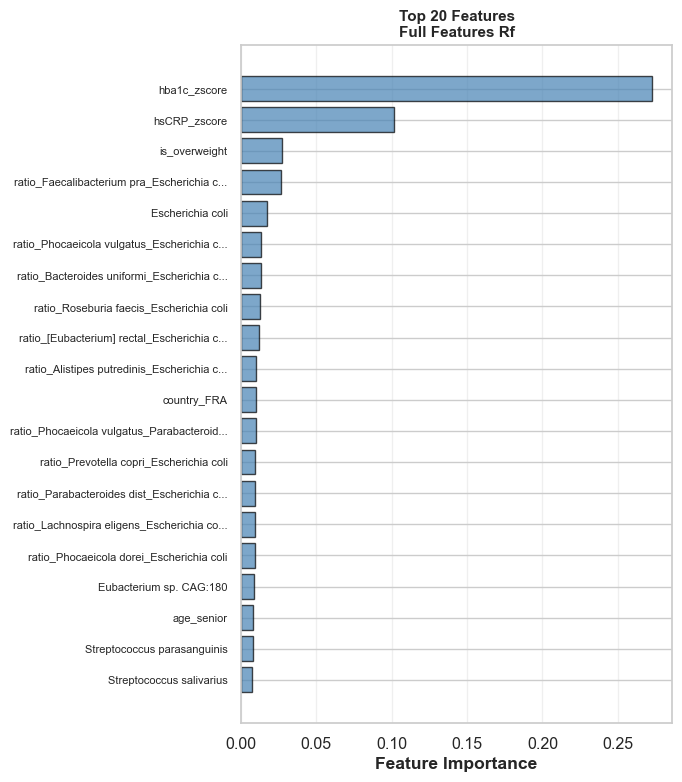

In [13]:
def plot_feature_importance_comparison(results_dict, top_n=20):
    """
    Plot top features for each model side-by-side.
    """
    # Filter models with feature importance
    models_with_fi = {k: v for k, v in results_dict.items()
                      if v['feature_importance'] is not None}

    n_models = len(models_with_fi)
    if n_models == 0:
        print("No models with feature importance to plot")
        return

    fig, axes = plt.subplots(1, n_models, figsize=(7*n_models, 8))

    if n_models == 1:
        axes = [axes]

    for ax, (model_name, result) in zip(axes, models_with_fi.items()):
        fi = result['feature_importance']
        top_features = fi.head(top_n)

        if 'coefficient' in fi.columns:
            # Logistic regression
            colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
            y_pos = np.arange(len(top_features))
            ax.barh(y_pos, top_features['coefficient'], color=colors, alpha=0.7, edgecolor='black')
            ax.set_xlabel('Coefficient\n(← Healthy | Disease →)', fontweight='bold')
        else:
            # Tree-based models
            y_pos = np.arange(len(top_features))
            ax.barh(y_pos, top_features['importance'], color='steelblue', alpha=0.7, edgecolor='black')
            ax.set_xlabel('Feature Importance', fontweight='bold')

        # Shorten feature names for display
        feature_labels = [f[:40] + '...' if len(f) > 40 else f
                         for f in top_features['feature']]
        ax.set_yticks(y_pos)
        ax.set_yticklabels(feature_labels, fontsize=8)
        ax.invert_yaxis()
        ax.set_title(f'Top {top_n} Features\n{model_name.replace("_", " ").title()}',
                    fontweight='bold', fontsize=11)
        ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'feature_importance_comparison.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

plot_feature_importance_comparison(results, top_n=20)


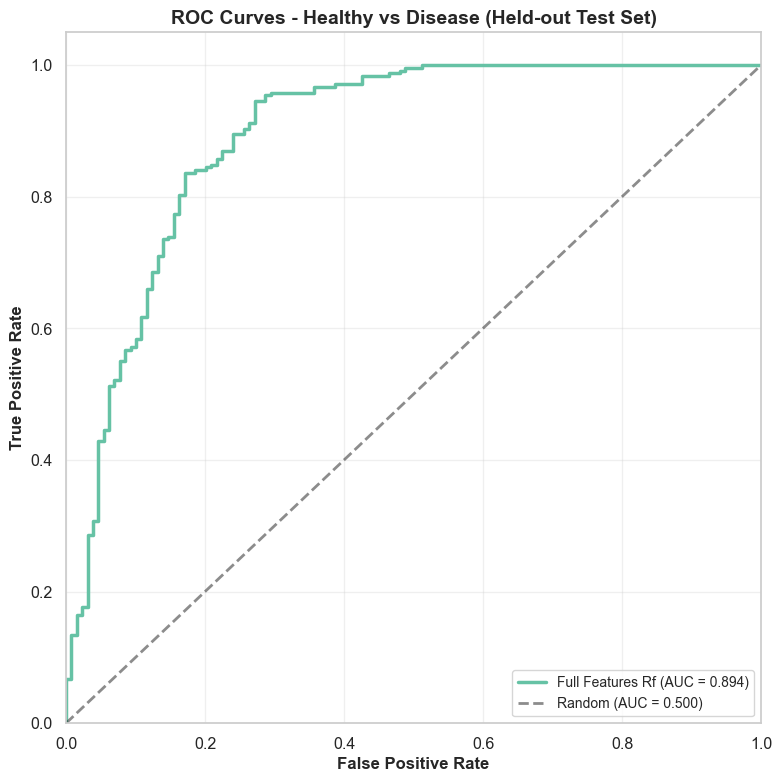

In [14]:
def plot_roc_curves_test_set(results_dict):
    """
    Plot ROC curves using the actual held-out test set predictions.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    colors = plt.cm.Set2(np.linspace(0, 1, len(results_dict)))

    for (model_name, result), color in zip(results_dict.items(), colors):
        y_test = result['y_test']
        y_prob = result['y_test_prob']

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Plot
        ax.plot(fpr, tpr, color=color, lw=2.5,
                label=f'{model_name.replace("_", " ").title()} (AUC = {roc_auc:.3f})')

    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)', alpha=0.5)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title('ROC Curves - Healthy vs Disease (Held-out Test Set)',
                fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'roc_curves_test_set.png'), dpi=300, bbox_inches='tight')
    plt.show()

plot_roc_curves_test_set(results)


# 7. Save Results

In [15]:

print("SAVING RESULTS")


# Create summary table
summary_data = []
for model_name, result in results.items():
    cv = result['cv_results']
    summary_data.append({
        'Model': model_name,
        'Model_Type': result['model_name'],
        'N_Train': len(result['X_train']),
        'N_Test': len(result['X_test']),
        'N_Features': result['X_train'].shape[1],
        'CV_ROC_AUC_mean': cv['roc_auc']['cv_mean'],
        'CV_ROC_AUC_std': cv['roc_auc']['cv_std'],
        'Test_ROC_AUC': cv['roc_auc']['test_score'],
        'Test_Balanced_Acc': cv['balanced_acc']['test_score'],
        'Test_Accuracy': cv['accuracy']['test_score'],
        'Test_Precision': cv['precision']['test_score'],
        'Test_Recall': cv['recall']['test_score'],
        'Test_F1': cv['f1']['test_score'],
        'Generalization_Gap': cv['roc_auc']['cv_mean'] - cv['roc_auc']['test_score']
    })

summary_df = pd.DataFrame(summary_data)

print("\nModel Performance Summary:")
print(summary_df.to_string(index=False))


SAVING RESULTS

Model Performance Summary:
           Model    Model_Type  N_Train  N_Test  N_Features  CV_ROC_AUC_mean  CV_ROC_AUC_std  Test_ROC_AUC  Test_Balanced_Acc  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Generalization_Gap
full_features_rf Random Forest     1464     367         150         0.919016        0.018061      0.894437           0.804573       0.850136        0.835165     0.957983 0.892368            0.024579


# 8. Final Summary & Key Findings

In [22]:

print("FINAL SUMMARY & KEY FINDINGS")


print(f"\nClassification Task: HEALTHY vs DISEASE")
print(f"  Total samples: {len(y)}")
print(f"  Training set: {len(y_train)} samples")
print(f"  Test set (held-out): {len(y_test)} samples")
print(f"  Disease prevalence: {(y==1).mean()*100:.1f}%")

print("MODEL RANKING (by Test Set ROC-AUC)")

# Sort models by test AUC
sorted_models = sorted(results.items(),
                      key=lambda x: x[1]['cv_results']['roc_auc']['test_score'],
                      reverse=True)

for rank, (model_name, result) in enumerate(sorted_models, 1):
    cv = result['cv_results']

    print(f"\nRank #{rank}: {model_name.upper().replace('_', ' ')}")
    print(f"  Model type:         {result['model_name']}")
    print(f"  Number of features: {result['X_train'].shape[1]}")

    print(f"\n  Cross-Validation Performance (on training set):")
    print(f"    CV ROC-AUC:     {cv['roc_auc']['cv_mean']:.3f} ± {cv['roc_auc']['cv_std']:.3f}")

    print(f"\n  Test Set Performance (held-out):")
    print(f"    ROC-AUC:        {cv['roc_auc']['test_score']:.3f}")
    print(f"    Balanced Acc:   {cv['balanced_acc']['test_score']:.3f}")
    print(f"    Accuracy:       {cv['accuracy']['test_score']:.3f}")
    print(f"    Precision:      {cv['precision']['test_score']:.3f}")
    print(f"    Recall:         {cv['recall']['test_score']:.3f}")
    print(f"    F1 Score:       {cv['f1']['test_score']:.3f}")

    # Generalization analysis
    gap = cv['roc_auc']['cv_mean'] - cv['roc_auc']['test_score']
    print(f"\n  Generalization Gap: {gap:+.3f}")
    if abs(gap) > 0.05:
        if gap > 0:
            print(f"Model may be slightly overfit (CV > Test)")
        else:
            print(f"Model generalizes excellently (Test > CV)")
    else:
        print(f"Good generalization")

    # Top features
    if result['feature_importance'] is not None:
        top_3 = result['feature_importance'].head(3)
        print(f"\n  Top 3 discriminative features:")
        for i, (_, row) in enumerate(top_3.iterrows(), 1):
            feat_name = row['feature'][:50]
            if 'coefficient' in row:
                direction = "↑ Disease" if row['coefficient'] > 0 else "↓ Disease"
                print(f"    {i}. {feat_name} {direction}")
            else:
                print(f"    {i}. {feat_name} (importance: {row['importance']:.4f})")

# Best model analysis
best_model_name = sorted_models[0][0]
best_result = sorted_models[0][1]


print("BEST MODEL")

print(f"Model: {best_model_name.upper().replace('_', ' ')}")
print(f"Test Set ROC-AUC: {best_result['cv_results']['roc_auc']['test_score']:.3f}")
print(f"CV ROC-AUC: {best_result['cv_results']['roc_auc']['cv_mean']:.3f}")

print(f"\nInterpretation:")
test_auc = best_result['cv_results']['roc_auc']['test_score']
if test_auc >= 0.9:
    print("  → Excellent predictive performance on held-out data")
elif test_auc >= 0.8:
    print("  → Good predictive performance on held-out data")
elif test_auc >= 0.7:
    print("  → Moderate predictive performance on held-out data")
else:
    print("  → Limited predictive performance")

# Confusion matrix for best model
print(f"\nConfusion Matrix (Test Set):")
cm = confusion_matrix(best_result['y_test'], best_result['y_test_pred'])
print(f"                Predicted")
print(f"              Healthy  Disease")
print(f"Actual Healthy   {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"       Disease   {cm[1,0]:4d}    {cm[1,1]:4d}")

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"\nSensitivity (Recall):    {sensitivity:.3f}")
print(f"Specificity:             {specificity:.3f}")


FINAL SUMMARY & KEY FINDINGS

Classification Task: HEALTHY vs DISEASE
  Total samples: 1831
  Training set: 1464 samples
  Test set (held-out): 367 samples
  Disease prevalence: 64.9%
MODEL RANKING (by Test Set ROC-AUC)

Rank #1: FULL FEATURES RF
  Model type:         Random Forest
  Number of features: 150

  Cross-Validation Performance (on training set):
    CV ROC-AUC:     0.919 ± 0.018

  Test Set Performance (held-out):
    ROC-AUC:        0.894
    Balanced Acc:   0.805
    Accuracy:       0.850
    Precision:      0.835
    Recall:         0.958
    F1 Score:       0.892

  Generalization Gap: +0.025
Good generalization

  Top 3 discriminative features:
    1. hba1c_zscore (importance: 0.2725)
    2. hsCRP_zscore (importance: 0.1013)
    3. is_overweight (importance: 0.0270)
BEST MODEL
Model: FULL FEATURES RF
Test Set ROC-AUC: 0.894
CV ROC-AUC: 0.919

Interpretation:
  → Good predictive performance on held-out data

Confusion Matrix (Test Set):
                Predicted
       

# Visualizations

SHAP Analysis, Classification Matrix & Feature Correlations


In [31]:
print(results)

{'full_features_rf': {'model': RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=20,
                       n_estimators=200, n_jobs=-1, random_state=2025), 'model_name': 'Random Forest', 'cv_results': {'roc_auc': {'cv_mean': np.float64(0.9190161231071257), 'cv_std': np.float64(0.01806128646657899), 'test_score': 0.894436844505244}, 'accuracy': {'cv_mean': np.float64(0.8859226705315816), 'cv_std': np.float64(0.012938102968685883), 'test_score': np.float64(0.8501362397820164)}, 'balanced_acc': {'cv_mean': np.float64(0.8511955089028632), 'cv_std': np.float64(0.017843408131950237), 'test_score': 0.8045729919874927}, 'precision': {'cv_mean': np.float64(0.8714761247342931), 'cv_std': np.float64(0.015926442251896558), 'test_score': np.float64(0.8351648351648352)}, 'recall': {'cv_mean': np.float64(0.9674014880132267), 'cv_std': np.float64(0.006987664198664319), 'test_score': np.float64(0.957983193277311)}, 'f1': {'cv_me

In [37]:
import shap
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform


## 1. SHAP Feature Importance Analysis

SHAP ANALYSIS FOR RANDOM FOREST MODEL

Generating SHAP values for model interpretation...
This may take a few minutes for 367 samples...
Raw SHAP values type: <class 'numpy.ndarray'>
Shape: (367, 150, 2)
SHAP values computed successfully!
Final shape: (367, 150)


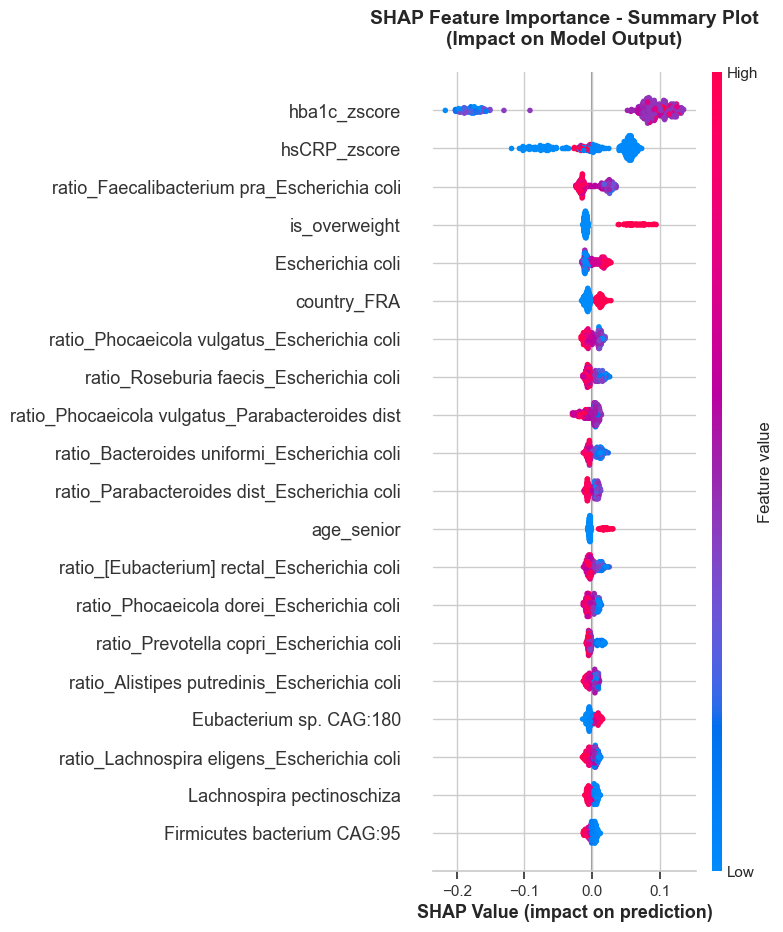

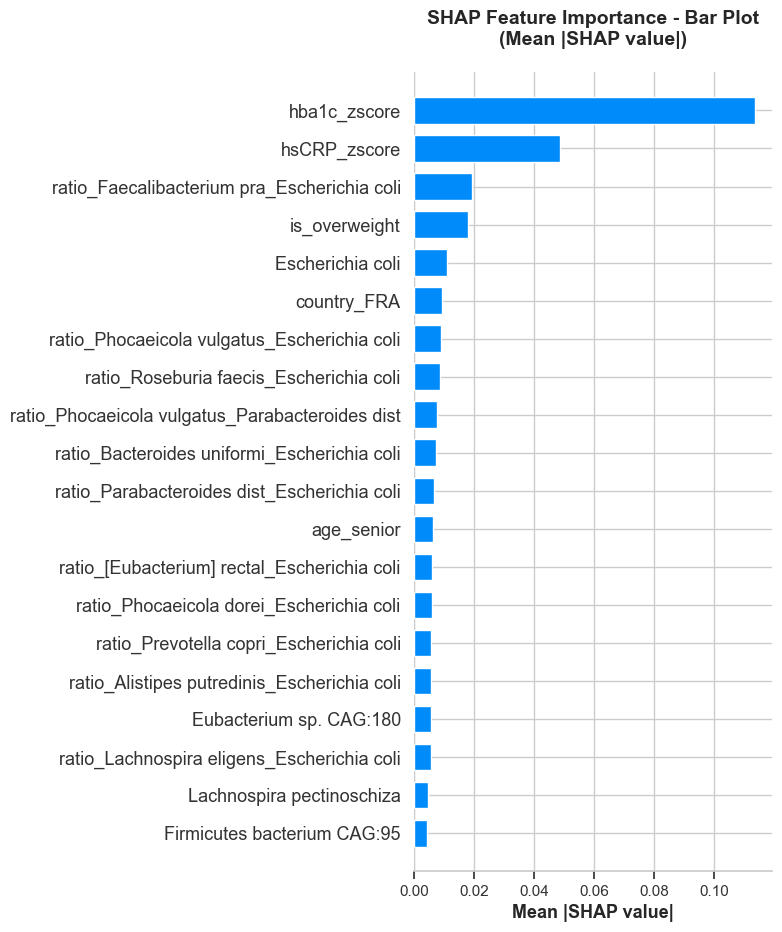


Top 15 Features by SHAP Importance:
                                        feature  mean_abs_shap
                                   hba1c_zscore       0.113711
                                   hsCRP_zscore       0.048751
    ratio_Faecalibacterium pra_Escherichia coli       0.019368
                                  is_overweight       0.018003
                               Escherichia coli       0.011006
                                    country_FRA       0.009258
    ratio_Phocaeicola vulgatus_Escherichia coli       0.008872
        ratio_Roseburia faecis_Escherichia coli       0.008748
ratio_Phocaeicola vulgatus_Parabacteroides dist       0.007568
    ratio_Bacteroides uniformi_Escherichia coli       0.007234
    ratio_Parabacteroides dist_Escherichia coli       0.006593
                                     age_senior       0.006262
    ratio_[Eubacterium] rectal_Escherichia coli       0.006019
       ratio_Phocaeicola dorei_Escherichia coli       0.005953
        ratio_Prev

In [46]:
def plot_shap_feature_importance(model, X_test, feature_names=None, 
                                  max_display=20, plot_type='both'):
    """
    Generate SHAP values and create comprehensive feature importance plots.
    
    Parameters:
    -----------
    model : trained model
    X_test : DataFrame or array - test set features
    feature_names : list - feature names (if X_test is array)
    max_display : int - number of top features to display
    plot_type : str - 'summary', 'bar', or 'both'
    """
    print(f"\nGenerating SHAP values for model interpretation...")
    print(f"This may take a few minutes for {X_test.shape[0]} samples...")
    
    # Convert to numpy if DataFrame
    if isinstance(X_test, pd.DataFrame):
        feature_names = X_test.columns.tolist()
        X_test_array = X_test.values
    else:
        X_test_array = X_test
        if feature_names is None:
            feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]
    
    # Create SHAP explainer
    # Use TreeExplainer for tree-based models (faster)
    if hasattr(model, 'estimators_'):  # Random Forest, Gradient Boosting
        explainer = shap.TreeExplainer(model)
        shap_values_raw = explainer.shap_values(X_test_array)
        
        print(f"Raw SHAP values type: {type(shap_values_raw)}")
        if isinstance(shap_values_raw, list):
            print(f"List length: {len(shap_values_raw)}")
            print(f"Shape of each element: {[s.shape for s in shap_values_raw]}")
        else:
            print(f"Shape: {shap_values_raw.shape}")
        
        # For binary classification, handle different SHAP output formats
        if isinstance(shap_values_raw, list):
            # TreeExplainer returns [shap_negative_class, shap_positive_class]
            shap_values = shap_values_raw[1]  # Use positive class (Disease)
        elif len(shap_values_raw.shape) == 3:
            # 3D array: (n_samples, n_features, n_classes)
            shap_values = shap_values_raw[:, :, 1]  # Use positive class
        else:
            # 2D array: (n_samples, n_features) - already for positive class
            shap_values = shap_values_raw
    else:
        # Use KernelExplainer for other models (slower but universal)
        explainer = shap.KernelExplainer(
            model.predict_proba, 
            shap.sample(X_test_array, 100)
        )
        shap_values_raw = explainer.shap_values(X_test_array)
        
        if isinstance(shap_values_raw, list):
            shap_values = shap_values_raw[1]
        elif len(shap_values_raw.shape) == 3:
            shap_values = shap_values_raw[:, :, 1]
        else:
            shap_values = shap_values_raw
    
    print(f"SHAP values computed successfully!")
    print(f"Final shape: {shap_values.shape}")
    
    # Create plots
    if plot_type in ['summary', 'both']:
        # 1. Summary plot (beeswarm)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values, 
            X_test_array, 
            feature_names=feature_names,
            max_display=max_display,
            show=False
        )
        plt.title('SHAP Feature Importance - Summary Plot\n(Impact on Model Output)', 
                  fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('SHAP Value (impact on prediction)', fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(ML_FIGS, 'shap_summary_plot.png'), 
                    dpi=300, bbox_inches='tight')
        plt.show()
    
    if plot_type in ['bar', 'both']:
        # 2. Mean absolute SHAP values (bar plot)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values, 
            X_test_array, 
            feature_names=feature_names,
            max_display=max_display,
            plot_type='bar',
            show=False
        )
        plt.title('SHAP Feature Importance - Bar Plot\n(Mean |SHAP value|)', 
                  fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Mean |SHAP value|', fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(ML_FIGS, 'shap_bar_plot.png'), 
                    dpi=300, bbox_inches='tight')
        plt.show()
    
    # 3. Create custom feature importance ranking
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    shap_importance_df = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    }).sort_values('mean_abs_shap', ascending=False)
    
    # Save to file
    shap_importance_df.to_csv(
        os.path.join(ML_TABLES, 'shap_feature_importance.csv'), 
        index=False
    )
    
    print(f"\nTop 15 Features by SHAP Importance:")
    print(shap_importance_df.head(15).to_string(index=False))
    
    return shap_values, shap_importance_df


# Generate SHAP plots for best model
print("="*80)
print("SHAP ANALYSIS FOR RANDOM FOREST MODEL")
print("="*80)

shap_values, shap_importance = plot_shap_feature_importance(
    results['full_features_rf']['model'],
    results['full_features_rf']['X_test'],
    max_display=20,
    plot_type='both'
)


## 2. Enhanced Classification Matrix (Punnett Square Style)


CLASSIFICATION MATRIX ANALYSIS


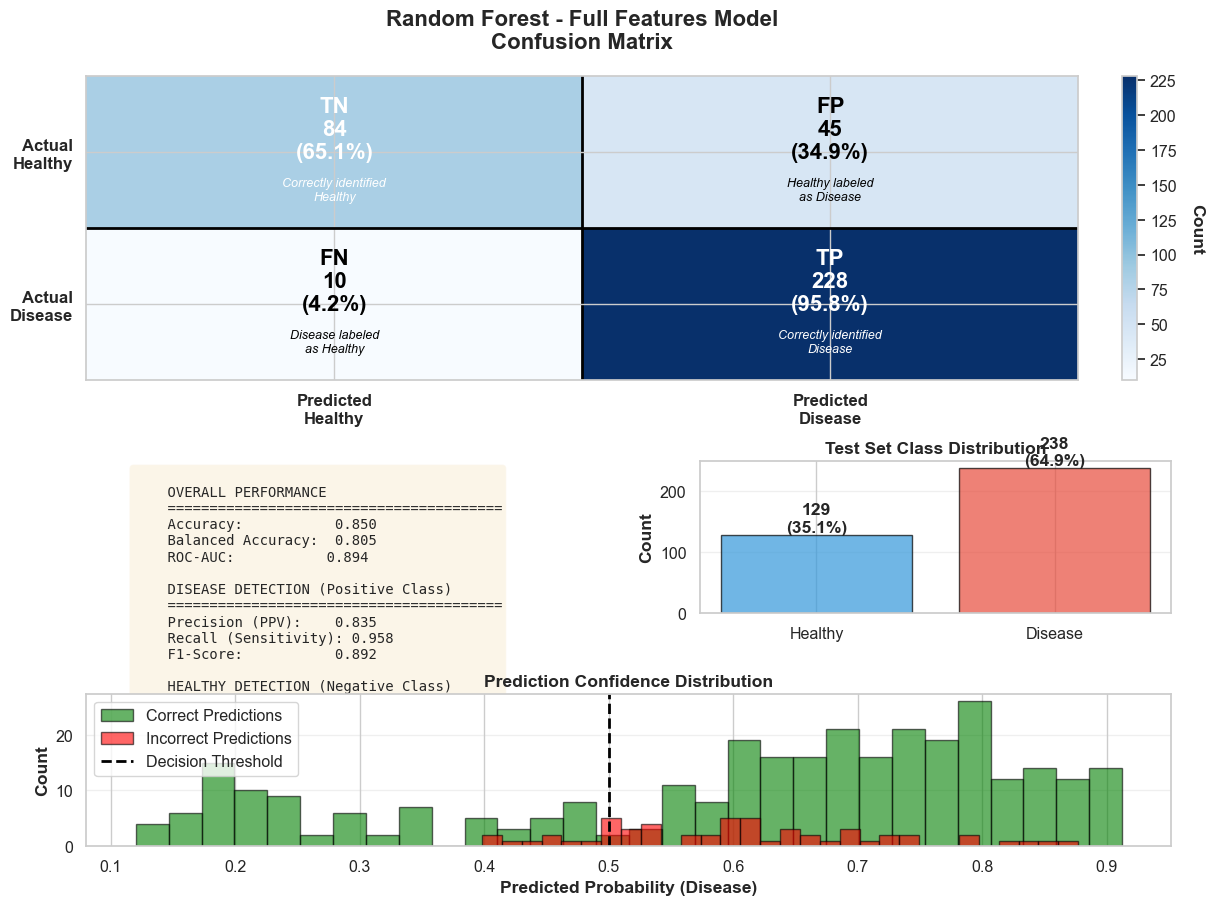


CLASSIFICATION RESULTS SUMMARY

Total Samples: 367
  Healthy: 129 (35.1%)
  Disease: 238 (64.9%)

Confusion Matrix:
  True Negatives (TN):  84
  False Positives (FP): 45
  False Negatives (FN): 10
  True Positives (TP):  228

Key Metrics:
  ROC-AUC:        0.894
  Accuracy:       0.850
  Balanced Acc:   0.805
  Sensitivity:    0.958
  Specificity:    0.651
  Precision:      0.835
  F1-Score:       0.892


In [47]:
def plot_classification_punnett_square(y_true, y_pred, y_prob,
                                        class_names=['Healthy', 'Disease'],
                                        title='Classification Results'):
    """
    Create an enhanced confusion matrix with detailed statistics
    styled like a Punnett square.

    Parameters:
    -----------
    y_true : array - true labels
    y_pred : array - predicted labels
    y_prob : array - prediction probabilities
    class_names : list - names of classes
    title : str - plot title
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    roc_auc = roc_auc_score(y_true, y_prob)

    # Create figure
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.4, wspace=0.3)

    # 1. Main confusion matrix (styled as Punnett square)
    ax_main = fig.add_subplot(gs[0, :])

    # Normalize for colors
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create custom colormap
    cmap = sns.color_palette("Blues", as_cmap=True)

    # Plot matrix
    im = ax_main.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax_main, fraction=0.046, pad=0.04)
    cbar.set_label('Count', rotation=270, labelpad=20, fontweight='bold')

    # Labels
    ax_main.set_xticks([0, 1])
    ax_main.set_yticks([0, 1])
    ax_main.set_xticklabels([f'Predicted\n{class_names[0]}',
                             f'Predicted\n{class_names[1]}'],
                            fontsize=12, fontweight='bold')
    ax_main.set_yticklabels([f'Actual\n{class_names[0]}',
                             f'Actual\n{class_names[1]}'],
                            fontsize=12, fontweight='bold')

    # Add cell annotations
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            pct = cm_norm[i, j] * 100

            # Cell label
            if i == 0 and j == 0:
                label = f'TN\n{count:,}\n({pct:.1f}%)'
                sublabel = 'Correctly identified\nHealthy'
            elif i == 0 and j == 1:
                label = f'FP\n{count:,}\n({pct:.1f}%)'
                sublabel = 'Healthy labeled\nas Disease'
            elif i == 1 and j == 0:
                label = f'FN\n{count:,}\n({pct:.1f}%)'
                sublabel = 'Disease labeled\nas Healthy'
            else:  # i == 1 and j == 1
                label = f'TP\n{count:,}\n({pct:.1f}%)'
                sublabel = 'Correctly identified\nDisease'

            # Main text
            text_color = 'white' if cm_norm[i, j] > 0.5 else 'black'
            ax_main.text(j, i - 0.15, label,
                        ha="center", va="center",
                        color=text_color, fontsize=16, fontweight='bold')

            # Sublabel
            ax_main.text(j, i + 0.25, sublabel,
                        ha="center", va="center",
                        color=text_color, fontsize=9, style='italic')

    ax_main.set_title(f'{title}\nConfusion Matrix',
                     fontsize=16, fontweight='bold', pad=20)

    # Add grid
    ax_main.set_xticks([0.5], minor=True)
    ax_main.set_yticks([0.5], minor=True)
    ax_main.grid(which='minor', color='black', linestyle='-', linewidth=2)

    # 2. Performance metrics panel
    ax_metrics = fig.add_subplot(gs[1, 0])
    ax_metrics.axis('off')

    metrics_text = f"""
    OVERALL PERFORMANCE
    {'='*40}
    Accuracy:           {accuracy:.3f}
    Balanced Accuracy:  {balanced_acc:.3f}
    ROC-AUC:           {roc_auc:.3f}

    DISEASE DETECTION (Positive Class)
    {'='*40}
    Precision (PPV):    {precision:.3f}
    Recall (Sensitivity): {recall:.3f}
    F1-Score:           {f1:.3f}

    HEALTHY DETECTION (Negative Class)
    {'='*40}
    Specificity (TNR):  {specificity:.3f}
    NPV:               {tn/(tn+fn) if (tn+fn)>0 else 0:.3f}
    """

    ax_metrics.text(0.1, 0.95, metrics_text,
                   transform=ax_metrics.transAxes,
                   fontsize=10, verticalalignment='top',
                   fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    # 3. Class distribution
    ax_dist = fig.add_subplot(gs[1, 1])

    total = len(y_true)
    n_healthy = (y_true == 0).sum()
    n_disease = (y_true == 1).sum()

    bars = ax_dist.bar([class_names[0], class_names[1]],
                       [n_healthy, n_disease],
                       color=['#3498DB', '#E74C3C'], alpha=0.7, edgecolor='black')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax_dist.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}\n({height/total*100:.1f}%)',
                    ha='center', va='bottom', fontweight='bold')

    ax_dist.set_ylabel('Count', fontweight='bold')
    ax_dist.set_title('Test Set Class Distribution', fontweight='bold')
    ax_dist.grid(axis='y', alpha=0.3)

    # 4. Prediction confidence distribution
    ax_conf = fig.add_subplot(gs[2, :])

    # Separate by correct/incorrect predictions
    correct_mask = (y_true == y_pred)

    ax_conf.hist(y_prob[correct_mask], bins=30, alpha=0.6,
                label='Correct Predictions', color='green', edgecolor='black')
    ax_conf.hist(y_prob[~correct_mask], bins=30, alpha=0.6,
                label='Incorrect Predictions', color='red', edgecolor='black')

    ax_conf.axvline(x=0.5, color='black', linestyle='--', linewidth=2,
                   label='Decision Threshold')
    ax_conf.set_xlabel('Predicted Probability (Disease)', fontweight='bold')
    ax_conf.set_ylabel('Count', fontweight='bold')
    ax_conf.set_title('Prediction Confidence Distribution', fontweight='bold')
    ax_conf.legend()
    ax_conf.grid(axis='y', alpha=0.3)

    plt.savefig(os.path.join(ML_FIGS, 'classification_punnett_square.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary
    print(f"\n{'='*60}")
    print(f"CLASSIFICATION RESULTS SUMMARY")
    print(f"{'='*60}")
    print(f"\nTotal Samples: {total:,}")
    print(f"  {class_names[0]}: {n_healthy:,} ({n_healthy/total*100:.1f}%)")
    print(f"  {class_names[1]}: {n_disease:,} ({n_disease/total*100:.1f}%)")
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives (TN):  {tn:,}")
    print(f"  False Positives (FP): {fp:,}")
    print(f"  False Negatives (FN): {fn:,}")
    print(f"  True Positives (TP):  {tp:,}")
    print(f"\nKey Metrics:")
    print(f"  ROC-AUC:        {roc_auc:.3f}")
    print(f"  Accuracy:       {accuracy:.3f}")
    print(f"  Balanced Acc:   {balanced_acc:.3f}")
    print(f"  Sensitivity:    {recall:.3f}")
    print(f"  Specificity:    {specificity:.3f}")
    print(f"  Precision:      {precision:.3f}")
    print(f"  F1-Score:       {f1:.3f}")


# Generate classification matrix
print("\n" + "="*80)
print("CLASSIFICATION MATRIX ANALYSIS")
print("="*80)

plot_classification_punnett_square(
    results['full_features_rf']['y_test'],
    results['full_features_rf']['y_test_pred'],
    results['full_features_rf']['y_test_prob'],
    class_names=['Healthy', 'Disease'],
    title='Random Forest - Full Features Model'
)


## 3. Feature Correlation Analysis


FEATURE CORRELATION ANALYSIS

Generating correlation analysis...
Using 30 specified features
Performing hierarchical clustering...


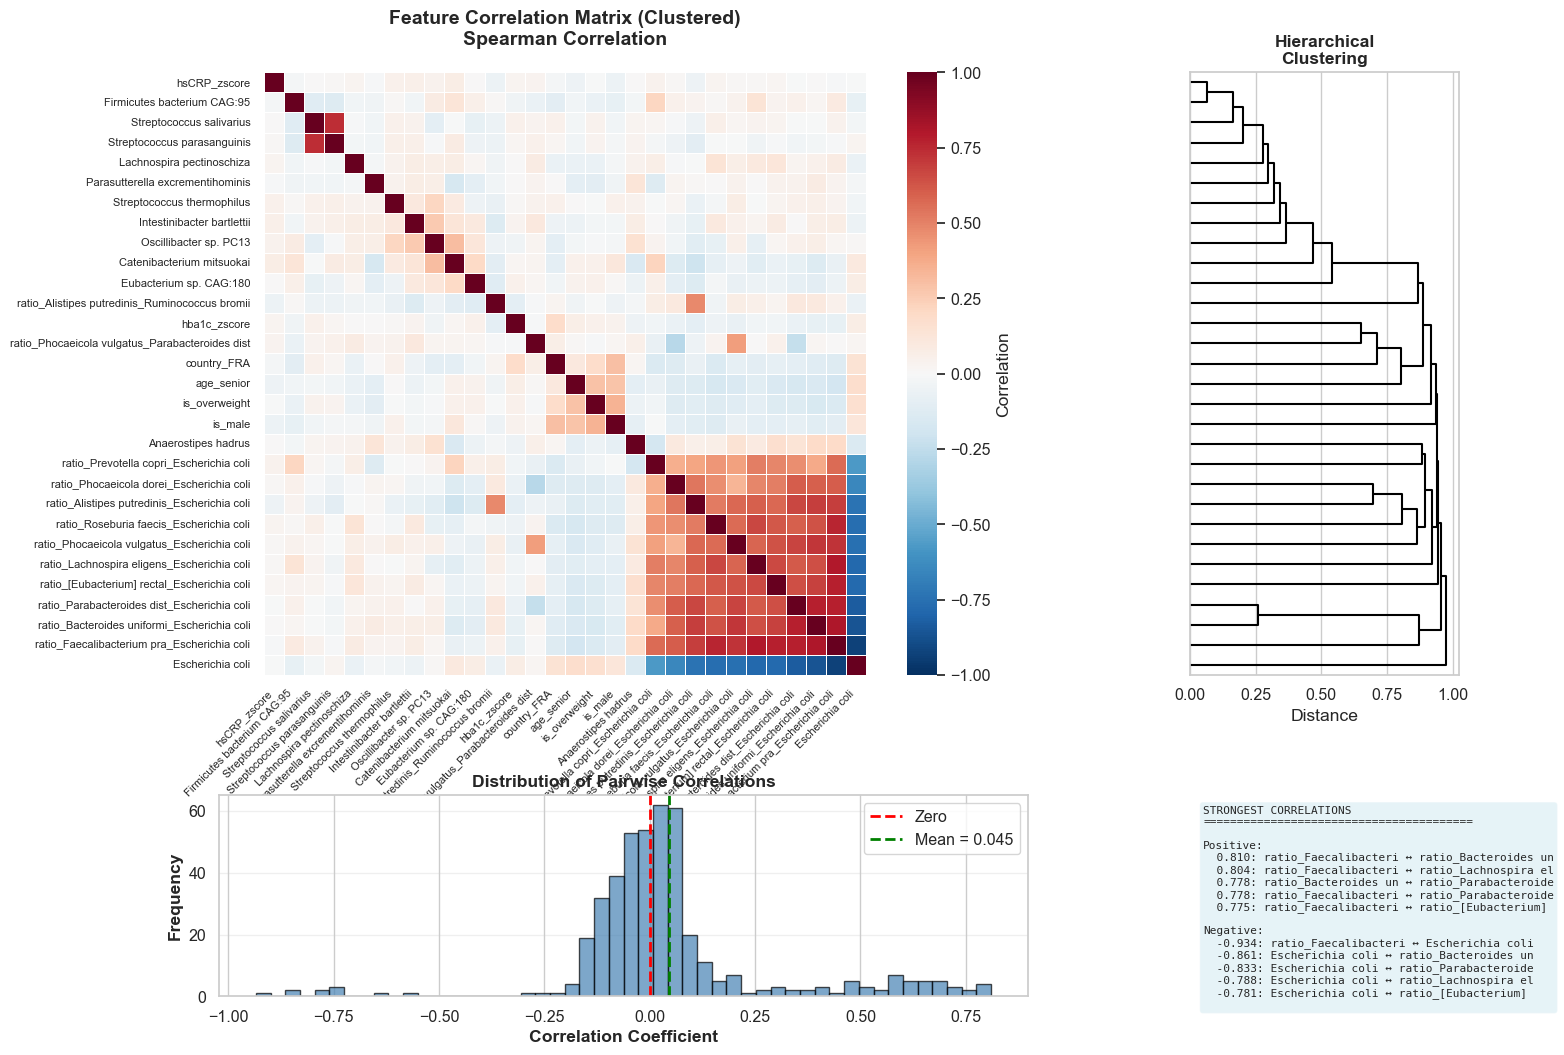


Correlation Statistics:
  Mean absolute correlation: 0.143
  Max positive correlation:  0.810
  Max negative correlation:  -0.934
  Highly correlated pairs (|r| > 0.8): 5


In [48]:
def plot_feature_correlations(X, top_features=None, n_features=30,
                               method='pearson', cluster=True):
    """
    Create comprehensive correlation plot for top features.

    Parameters:
    -----------
    X : DataFrame - feature matrix
    top_features : list - specific features to include
    n_features : int - number of top features to show
    method : str - 'pearson', 'spearman', or 'kendall'
    cluster : bool - whether to cluster features by similarity
    """
    print(f"\nGenerating correlation analysis...")

    # Select features
    if top_features is not None:
        # Use provided features
        X_subset = X[top_features]
        print(f"Using {len(top_features)} specified features")
    else:
        # Use top N by variance
        variances = X.var().sort_values(ascending=False)
        top_features = variances.head(n_features).index
        X_subset = X[top_features]
        print(f"Using top {n_features} features by variance")

    # Calculate correlation matrix
    corr = X_subset.corr(method=method)

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[3, 1],
                          hspace=0.3, wspace=0.3)

    # 1. Main correlation heatmap
    ax_main = fig.add_subplot(gs[0, 0])

    if cluster:
        # Hierarchical clustering
        print("Performing hierarchical clustering...")
        # Calculate linkage
        condensed_corr = squareform(1 - corr.abs())
        linkage = hierarchy.linkage(condensed_corr, method='average')
        dendro_order = hierarchy.dendrogram(linkage, no_plot=True)['leaves']

        # Reorder correlation matrix
        corr_clustered = corr.iloc[dendro_order, dendro_order]

        # Plot
        sns.heatmap(corr_clustered, annot=False, fmt='.2f',
                   cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                   square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'},
                   ax=ax_main)
        ax_main.set_title(f'Feature Correlation Matrix (Clustered)\n{method.capitalize()} Correlation',
                         fontsize=14, fontweight='bold', pad=20)
    else:
        # No clustering
        sns.heatmap(corr, annot=False, fmt='.2f',
                   cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                   square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'},
                   ax=ax_main)
        ax_main.set_title(f'Feature Correlation Matrix\n{method.capitalize()} Correlation',
                         fontsize=14, fontweight='bold', pad=20)

    # Rotate labels
    ax_main.set_xticklabels(ax_main.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax_main.set_yticklabels(ax_main.get_yticklabels(), rotation=0, fontsize=8)

    # 2. Dendrogram (if clustering)
    if cluster:
        ax_dendro = fig.add_subplot(gs[0, 1])
        hierarchy.dendrogram(linkage, orientation='right', ax=ax_dendro,
                           color_threshold=0, above_threshold_color='black')
        ax_dendro.set_title('Hierarchical\nClustering', fontweight='bold')
        ax_dendro.set_xlabel('Distance')
        ax_dendro.set_yticks([])

    # 3. Correlation distribution
    ax_dist = fig.add_subplot(gs[1, 0])

    # Get upper triangle correlations (excluding diagonal)
    mask = np.triu(np.ones_like(corr), k=1).astype(bool)
    upper_tri_corr = corr.where(mask).stack().values

    ax_dist.hist(upper_tri_corr, bins=50, color='steelblue',
                alpha=0.7, edgecolor='black')
    ax_dist.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
    ax_dist.axvline(x=upper_tri_corr.mean(), color='green',
                   linestyle='--', linewidth=2,
                   label=f'Mean = {upper_tri_corr.mean():.3f}')

    ax_dist.set_xlabel('Correlation Coefficient', fontweight='bold')
    ax_dist.set_ylabel('Frequency', fontweight='bold')
    ax_dist.set_title('Distribution of Pairwise Correlations', fontweight='bold')
    ax_dist.legend()
    ax_dist.grid(axis='y', alpha=0.3)

    # 4. Top correlated pairs
    ax_pairs = fig.add_subplot(gs[1, 1])
    ax_pairs.axis('off')

    # Find top positive and negative correlations
    corr_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            corr_pairs.append({
                'feature1': corr.columns[i],
                'feature2': corr.columns[j],
                'correlation': corr.iloc[i, j]
            })

    corr_df = pd.DataFrame(corr_pairs)

    # Top positive
    top_pos = corr_df.nlargest(5, 'correlation')
    # Top negative
    top_neg = corr_df.nsmallest(5, 'correlation')

    pairs_text = "STRONGEST CORRELATIONS\n" + "="*40 + "\n\n"
    pairs_text += "Positive:\n"
    for _, row in top_pos.iterrows():
        f1 = row['feature1'][:20]
        f2 = row['feature2'][:20]
        pairs_text += f"  {row['correlation']:.3f}: {f1} ↔ {f2}\n"

    pairs_text += "\nNegative:\n"
    for _, row in top_neg.iterrows():
        f1 = row['feature1'][:20]
        f2 = row['feature2'][:20]
        pairs_text += f"  {row['correlation']:.3f}: {f1} ↔ {f2}\n"

    ax_pairs.text(0.05, 0.95, pairs_text,
                 transform=ax_pairs.transAxes,
                 fontsize=8, verticalalignment='top',
                 fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

    plt.savefig(os.path.join(ML_FIGS, f'feature_correlations_{method}.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # Save correlation matrix
    corr.to_csv(os.path.join(ML_TABLES, f'correlation_matrix_{method}.csv'))

    print(f"\nCorrelation Statistics:")
    print(f"  Mean absolute correlation: {np.abs(upper_tri_corr).mean():.3f}")
    print(f"  Max positive correlation:  {upper_tri_corr.max():.3f}")
    print(f"  Max negative correlation:  {upper_tri_corr.min():.3f}")
    print(f"  Highly correlated pairs (|r| > 0.8): {(np.abs(upper_tri_corr) > 0.8).sum()}")

    return corr


# Generate correlation plots
print("\n" + "="*80)
print("FEATURE CORRELATION ANALYSIS")
print("="*80)

# Option 1: Correlation of all features (might be too large)
# Use top features from SHAP or feature importance
top_30_features = shap_importance.head(30)['feature'].tolist()

corr_matrix = plot_feature_correlations(
    results['full_features_rf']['X_train'],
    top_features=top_30_features,
    method='spearman',  # Spearman for microbiome data (often non-normal)
    cluster=True
)



Generating correlation analysis...
Using 30 specified features
Performing hierarchical clustering...


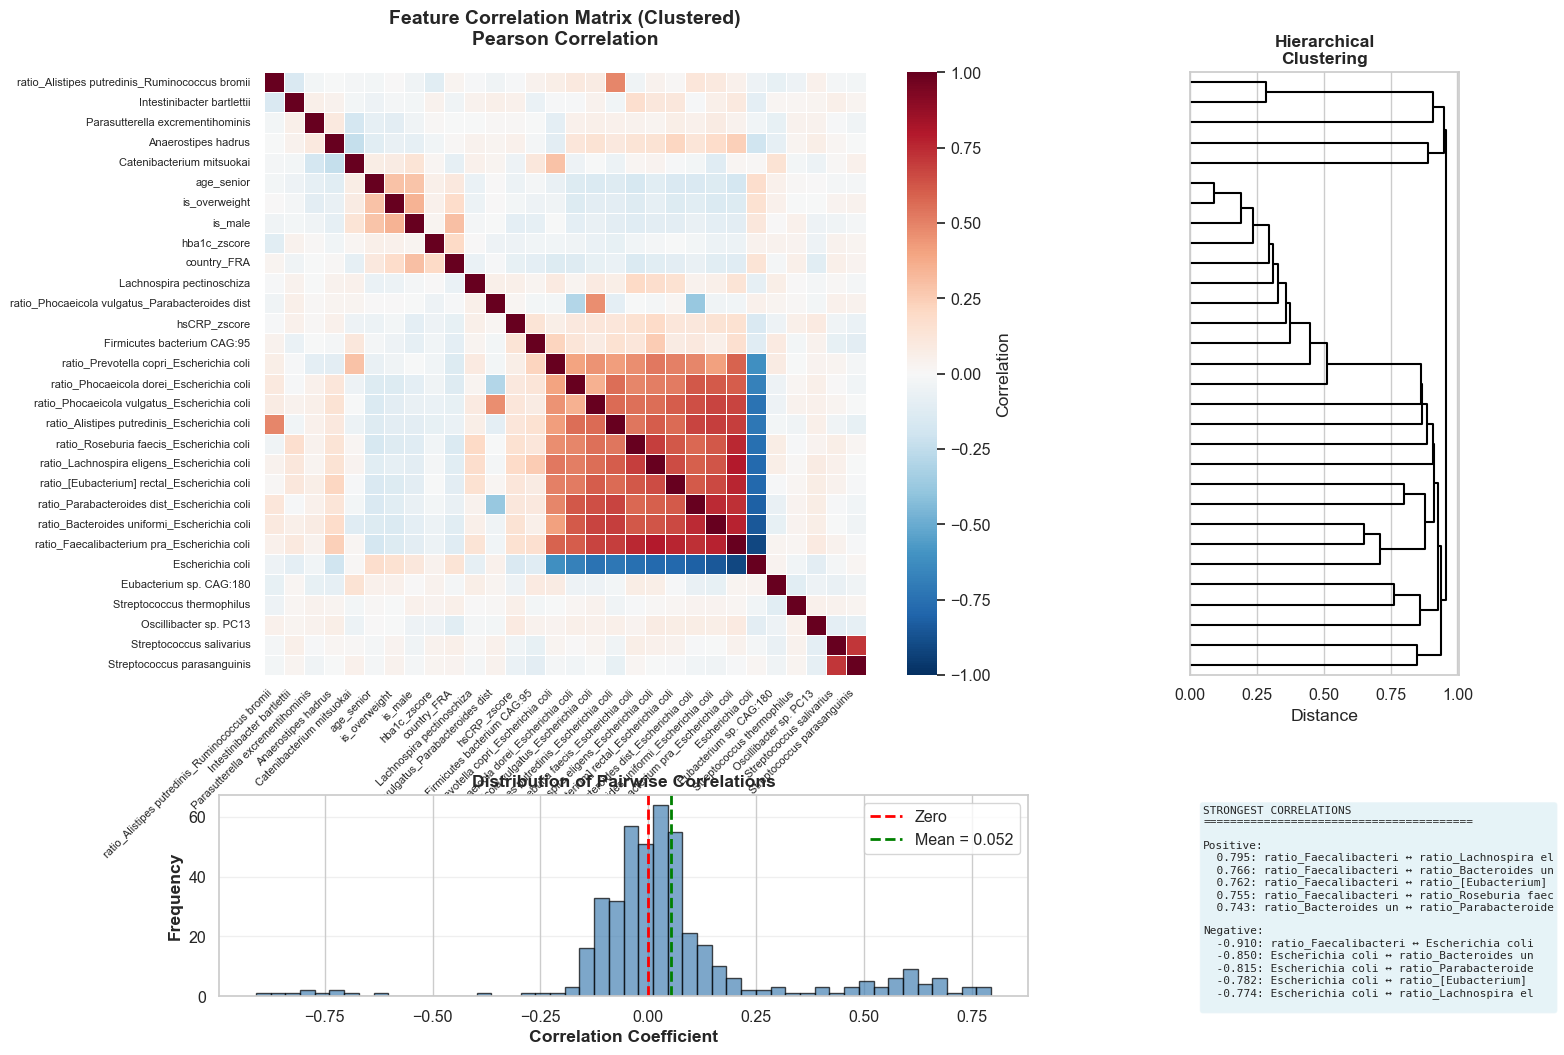


Correlation Statistics:
  Mean absolute correlation: 0.144
  Max positive correlation:  0.795
  Max negative correlation:  -0.910
  Highly correlated pairs (|r| > 0.8): 3


In [49]:
# Also create a Pearson correlation for comparison
corr_matrix_pearson = plot_feature_correlations(
    results['full_features_rf']['X_train'],
    top_features=top_30_features,
    method='pearson',
    cluster=True
)


## 4. Combined Feature Importance Comparison


FEATURE IMPORTANCE METHOD COMPARISON


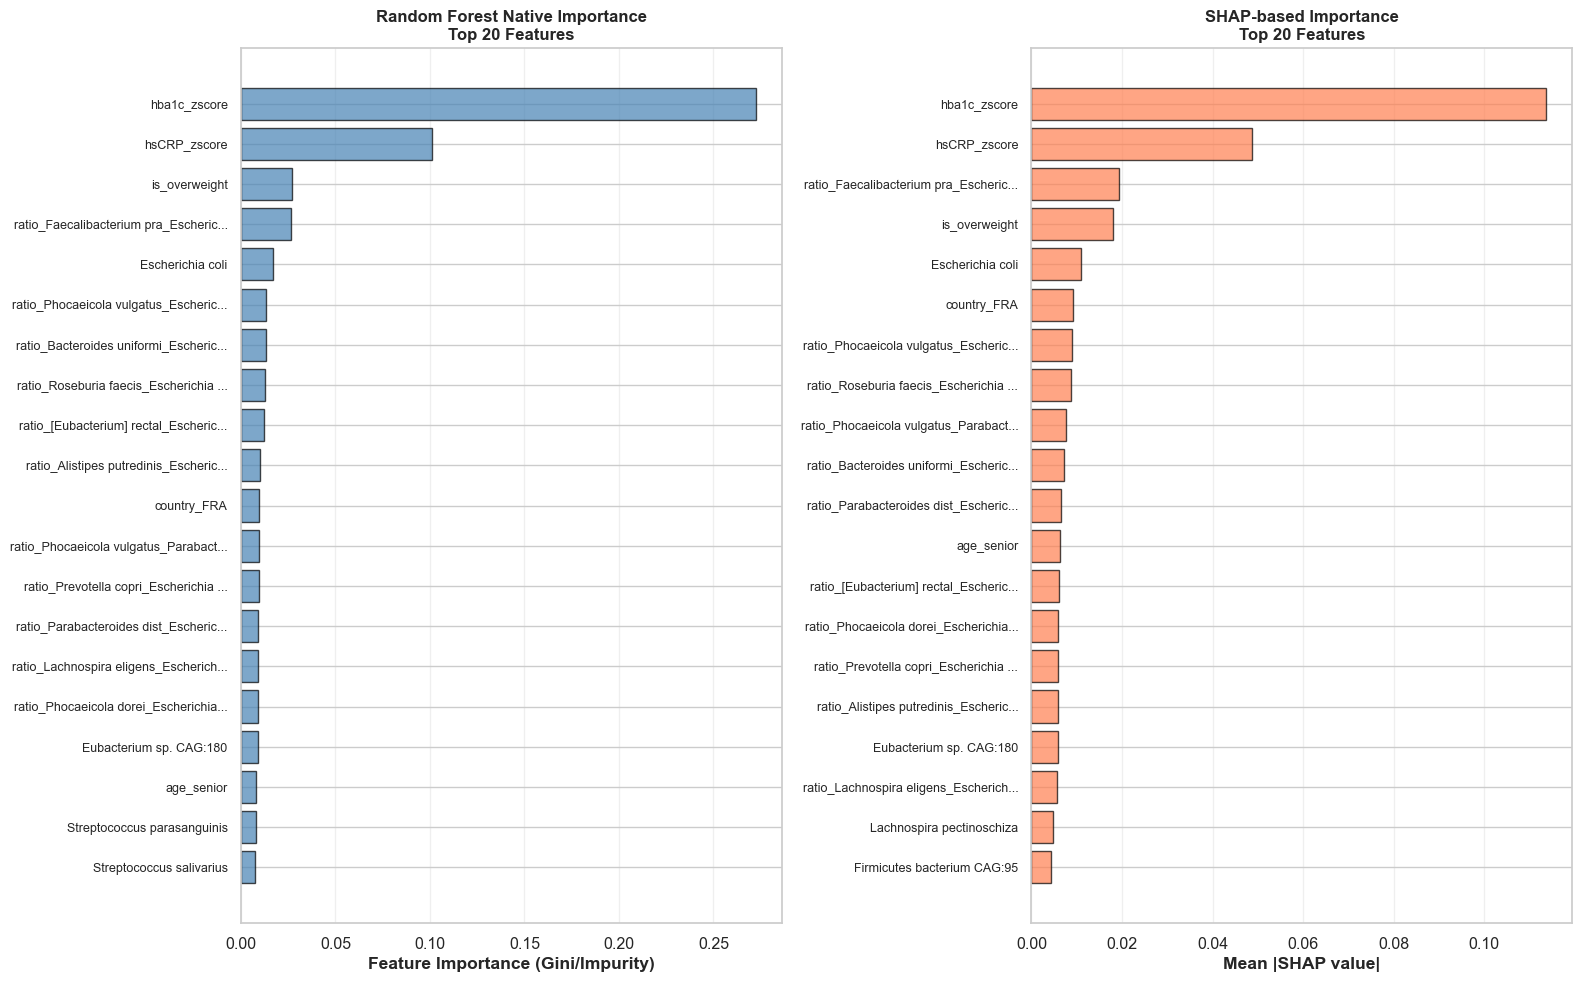


ALL VISUALIZATIONS COMPLETED!

Generated files saved in: data/results_EDA/ml_figures

Visualizations created:
  1. SHAP summary plot (beeswarm)
  2. SHAP bar plot (mean importance)
  3. Classification Punnett square (enhanced confusion matrix)
  4. Feature correlation heatmap (Spearman)
  5. Feature correlation heatmap (Pearson)
  6. Feature importance method comparison


In [50]:
def compare_feature_importance_methods(model, X_train, X_test,
                                       shap_importance_df,
                                       rf_importance_df=None,
                                       top_n=20):
    """
    Compare different feature importance methods side by side.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))

    # 1. Model's native importance (Random Forest)
    if rf_importance_df is not None:
        ax = axes[0]
        top_rf = rf_importance_df.head(top_n)

        y_pos = np.arange(len(top_rf))
        ax.barh(y_pos, top_rf['importance'], color='steelblue',
               alpha=0.7, edgecolor='black')

        feature_labels = [f[:35] + '...' if len(f) > 35 else f
                         for f in top_rf['feature']]
        ax.set_yticks(y_pos)
        ax.set_yticklabels(feature_labels, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('Feature Importance (Gini/Impurity)', fontweight='bold')
        ax.set_title(f'Random Forest Native Importance\nTop {top_n} Features',
                    fontweight='bold', fontsize=12)
        ax.grid(axis='x', alpha=0.3)

    # 2. SHAP importance
    ax = axes[1]
    top_shap = shap_importance_df.head(top_n)

    y_pos = np.arange(len(top_shap))
    ax.barh(y_pos, top_shap['mean_abs_shap'], color='coral',
           alpha=0.7, edgecolor='black')

    feature_labels = [f[:35] + '...' if len(f) > 35 else f
                     for f in top_shap['feature']]
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_labels, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Mean |SHAP value|', fontweight='bold')
    ax.set_title(f'SHAP-based Importance\nTop {top_n} Features',
                fontweight='bold', fontsize=12)
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'feature_importance_comparison_methods.png'),
                dpi=300, bbox_inches='tight')
    plt.show()


# Compare importance methods
print("\n" + "="*80)
print("FEATURE IMPORTANCE METHOD COMPARISON")
print("="*80)

compare_feature_importance_methods(
    results['full_features_rf']['model'],
    results['full_features_rf']['X_train'],
    results['full_features_rf']['X_test'],
    shap_importance,
    results['full_features_rf']['feature_importance'],
    top_n=20
)

print("\n" + "="*80)
print("ALL VISUALIZATIONS COMPLETED!")
print("="*80)
print(f"\nGenerated files saved in: {ML_FIGS}")
print("\nVisualizations created:")
print("  1. SHAP summary plot (beeswarm)")
print("  2. SHAP bar plot (mean importance)")
print("  3. Classification Punnett square (enhanced confusion matrix)")
print("  4. Feature correlation heatmap (Spearman)")
print("  5. Feature correlation heatmap (Pearson)")
print("  6. Feature importance method comparison")